# ASR decoder 

Example how to build an ASR decoder. We consider a decoder with the following lexicon:

|  Word | Pronunciation | 
|:-----:|:--------------|
| zero  | z e r o       |
| one   | o n e         |            
| two   | t w o         |
| three | t h r e e     |
| three | s r e e       |
| four  | f o u r       |
| five  | f i v e       |
| six   | s i x         |
| seven | s e v e n     |
| eight | e i g h t     |
| nine  | n i n e       |
 
Note that, for simplicity, we use the letters as phones. Also, every word has a single pronunciation except "three" which can be pronunced "three" and "sree".  

In [1]:
using Pkg
Pkg.activate("../")

using Revise
using MarkovModels

 Activating environment at `~/GithubRepositories/MarkovModels/Project.toml`


## HMMs

We build an HMM each phone (in this case letters). Each phone is modeled by a 3-state left-to-right HMM.

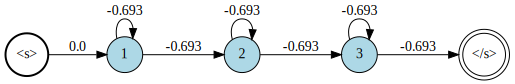

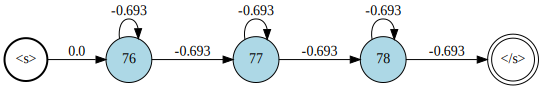

In [3]:
function makehmm(pdfidxs)
    fsm = FSM{Float64}()
    
    prevstate = initstate(fsm)
    for pdfidx in pdfidxs
        state = addstate!(fsm, pdfindex = pdfidx)
        link!(state, state)
        link!(prevstate, state)
        prevstate = state
    end
    link!(prevstate, finalstate(fsm))
    
    fsm |> weightnormalize
end

hmms = Dict()
countpdfs = 0
for (i, l) in enumerate('a':'z')
    startidx = 3 * (i -1) + 1
    countpdfs += 3
    hmms["$l"] = makehmm([startidx, startidx + 1, startidx + 2])
end

phones = collect('a':'z')

display(hmms["a"])
display(hmms["z"])

## Lexicon

Now we build the FSM lexicon

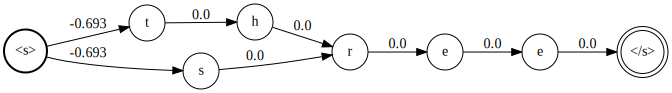

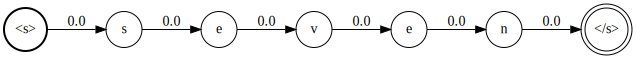

In [4]:
raw_lexicon = Dict(
    "zero"  => [("z", "e", "r", "o")],
    "one"   => [("o", "n", "e")],
    "two"   => [("t", "w", "o")],
    "three" => [("t", "h", "r", "e", "e"),
                ("s", "r", "e", "e")],  
    "four"  => [("f", "o", "u", "r")],
    "five"  => [("f", "i", "v", "e")],
    "six"   => [("s", "i", "x")],
    "seven" => [("s", "e", "v", "e", "n")],
    "eight" => [("e", "i", "g", "h", "t")],
    "nine"  => [("n", "i", "n", "e")]
)

function makepronunciation(pronunciation)
    fsm = FSM{Float64}()
    
    prevstate = initstate(fsm)
    for phone in pronunciation
        state = addstate!(fsm, label = phone)
        link!(prevstate, state)
        prevstate = state
    end
    link!(prevstate, finalstate(fsm))
    
    fsm
end

lexicon = Dict()
for (word, pronunciations) in raw_lexicon
    lexicon[word] = union(makepronunciation.(pronunciations)...) |> weightnormalize |> minimize
end

words = collect(keys(lexicon))

display(lexicon["three"])
display(lexicon["seven"])

## Language Model

We simply assume a flat unigram language model

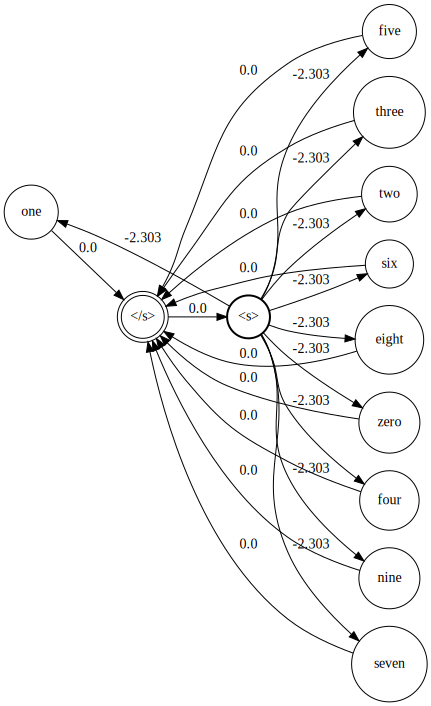

In [5]:
words = keys(lexicon)

# Create a simple unigram language model
lm = FSM{Float64}()
for word in keys(lexicon)
    s = addstate!(lm, label = word)
    link!(initstate(lm), s)
    link!(s, finalstate(lm))
end
link!(finalstate(lm), initstate(lm))

lm = lm |> weightnormalize

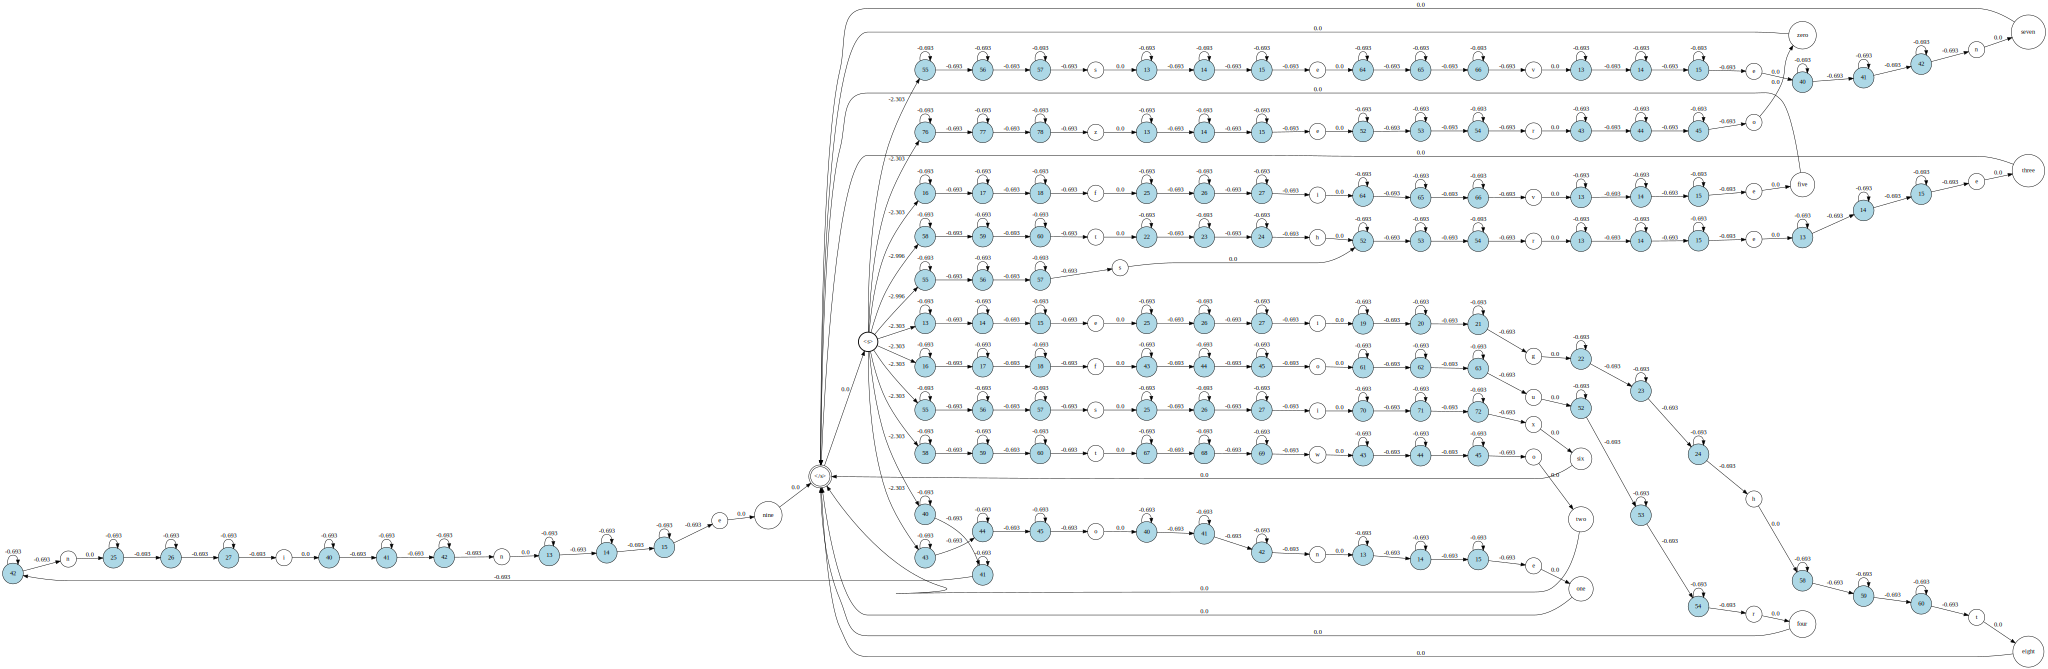

In [6]:
decoder = (hmms ∘ (lexicon ∘ lm)) |> removenilstates

## Generating a lattice

In [50]:
D,N = countpdfs, 50 # number of distributions times number of frames
llh = randn(D, N)

78×50 Array{Float64,2}:
  0.258419  -0.150416   0.0594726  …  -0.454533    0.400663    0.456256
 -0.893163   0.835275   0.656094      -0.781024    0.360511    0.227639
  1.59277   -0.559943  -0.962772       2.05263     0.132028    0.766202
 -0.471028   0.450332   0.714262       0.173393   -1.66244     0.979299
  1.78448    0.876037   1.72013        0.331065    0.147686   -0.469206
  0.67954    0.27473   -0.478372   …  -0.973776    0.77002    -1.22542
 -0.255546   1.3759    -1.43134        0.330761    0.400423   -1.23652
  1.37208   -0.602982  -0.829244       1.23624     0.53207     1.42591
 -1.31992    1.45426   -1.10413       -0.31109     0.0439829   1.47246
 -0.743205  -0.187647  -0.506491      -1.19464     0.725246    0.522977
 -0.649256  -2.51967   -1.1183     …  -0.712381    0.509604   -2.8203
  0.731928  -0.199484  -0.118766       0.837102   -0.067188   -0.946604
  0.941935  -1.29487   -0.594396      -0.230281    1.02494    -0.225066
  ⋮                                ⋱          

## Decoding 
### Word level

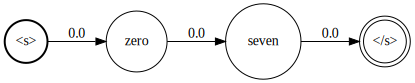

In [54]:
bestpath(decoder, llh, statefilter = x -> x.label ∈ keys(lexicon))

### Phone level

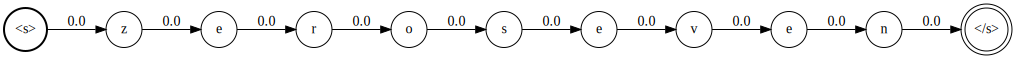

In [55]:
bestpath(decoder, llh, statefilter = x -> x.label ∈ keys(hmms))

## Generating lattice
### Word lattice

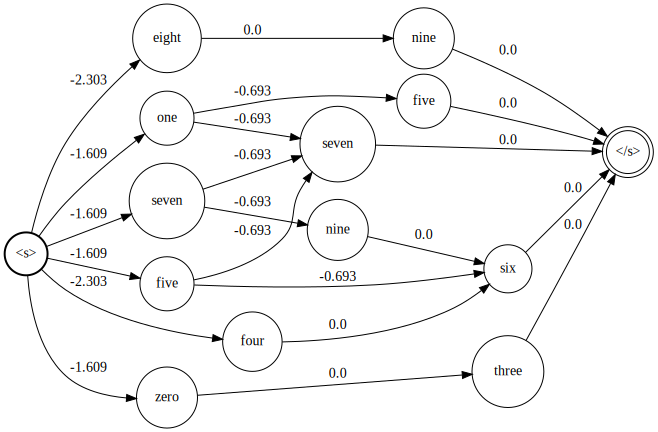

In [56]:
paths = union(samplepath(decoder, llh, size = 10, statefilter = x -> x.label ∈ keys(lexicon))...) |> minimize

### Phone lattice

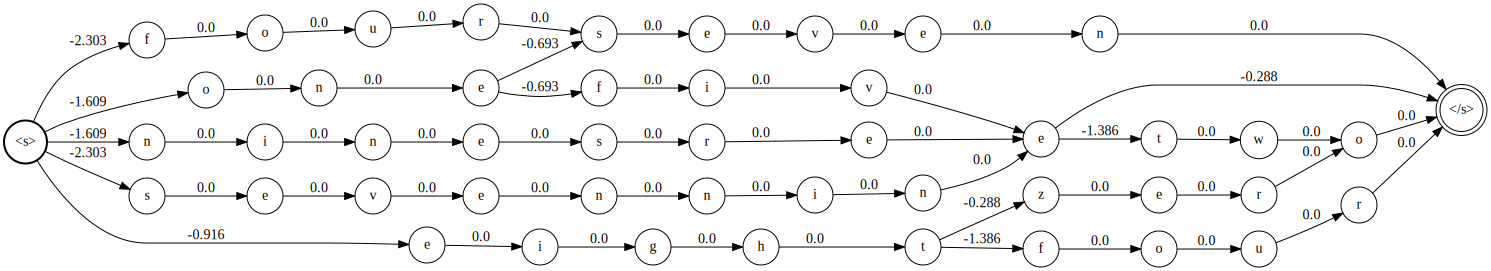

In [57]:
paths = union(samplepath(decoder, llh, size = 10, statefilter = x -> x.label ∈ keys(hmms))...) |> minimize